# Metropolis Hastings

## Homework

---

### Q1

Convert your **Gibbs sampler** from the previous homework to be a **Metropolis within Gibbs** sampler.

- instructions for proposal and prior:

- Do not derive any full conditionals and instead just use the joint distribution which is the product of the likelihood with the priors
    - Note that in fact you must only be proportional to the joint since irrelevant priors of "the other parameter" will cancel in the ratio
- Note that $\tau$ must be positive so proposals $\tilde \tau$ must also be positive. The easiest way to achieve this would be to use independent samples (that do not depend on $\tau^{(t-1)}$ from exponential, half normal, gamma, or inverse gamma distributions (and other distributions defining strictly positive random variables).
- When considering using independent proposal distributions one option of some note is to use the prior $p(\tau)$ as this proposal distribution

*Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).*

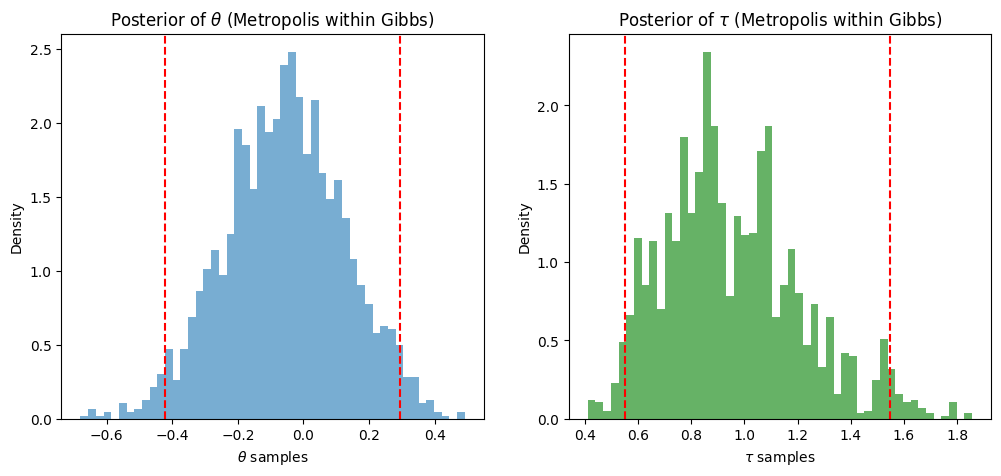

95% Credible Interval for θ (Metropolis within Gibbs): [-0.42103, 0.29529]
95% Credible Interval for τ (Metropolis within Gibbs): [0.54934, 1.54630]


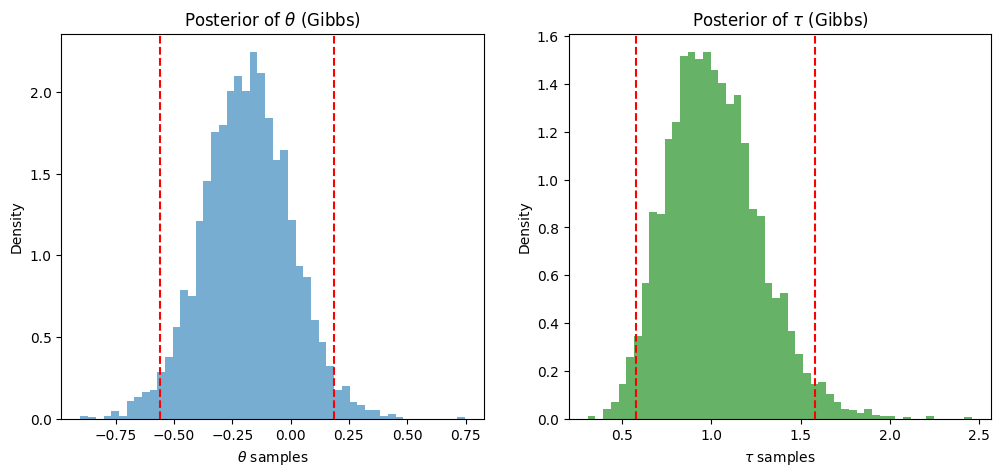

95% Credible Interval for θ (Gibbs): [-0.56041, 0.18421]
95% Credible Interval for τ (Gibbs): [0.57736, 1.58387]


In [ ]:
import numpy as np
from scipy.stats import norm, gamma, expon
import matplotlib.pyplot as plt

np.random.seed(1)

def joint_posterior(theta, tau, data, theta0, tau0, alpha, lambd):
    """
    Computes the unnormalized joint posterior:
    p(theta, tau | x) ∝ p(x | theta, tau) * p(theta) * p(tau)

    Args:
      theta  : proposed mean
      tau    : proposed precision
      data   : observed data (array)
      theta0 : prior mean for theta
      tau0   : prior precision for theta
      alpha  : shape of Gamma prior for tau
      lambd  : rate of Gamma prior for tau
    Returns:
      Unnormalized posterior probability
    """
    n = len(data)

    # Likelihood: N(θ, 1/τ) (loc=mean, scale=stdev)
    likelihood = norm.pdf(data, loc=theta, scale=1/np.sqrt(tau)).prod()

    # Prior for θ: N(θ_0, 1/τ_0)
    prior_theta = norm.pdf(theta, loc=theta0, scale=1/np.sqrt(tau0))

    # Prior for τ: Gamma(shape alpha, rate lambda)
    prior_tau = gamma.pdf(tau, a=alpha, scale=1/lambd)

    return likelihood * prior_theta * prior_tau

def metropolis_update_theta(theta_current, tau, data, theta0, tau0, alpha, lambd, prop_sd_theta):
    """
    Metropolis update for θ using a normal proposal.
    """
    # propose a new θ ~ Normal(θ_current, prop_sd_theta)
    theta_proposed = norm.rvs(loc=theta_current, scale=prop_sd_theta)

    # get joint posterior probabilities of proposed and existing theta
    p_proposed = joint_posterior(theta_proposed, tau, data, theta0, tau0, alpha, lambd)
    p_current = joint_posterior(theta_current, tau, data, theta0, tau0, alpha, lambd)

    acceptance_ratio = p_proposed / p_current
    if np.random.rand() < min(1, acceptance_ratio):
        return theta_proposed  # accept proposal
    return theta_current  # reject

def metropolis_update_tau(theta, tau_current, data, theta0, tau0, alpha, lambd):
    """
    Metropolis update step for τ using an exponential proposal.
    """
    # propose a new τ from an Exp(2) dist
    tau_proposed = expon.rvs(scale=2)

    # get joint posterior probabilities
    p_proposed = joint_posterior(theta, tau_proposed, data, theta0, tau0, alpha, lambd)
    p_current = joint_posterior(theta, tau_current, data, theta0, tau0, alpha, lambd)

    # α(τ* | τ) = min(1, p(τ*) / p(τ) * (q(τ | τ*) / q(τ* | τ)))
    proposal_ratio = expon.pdf(tau_current, scale=2) / expon.pdf(tau_proposed, scale=2)
    acceptance_ratio = (p_proposed / p_current) * proposal_ratio

    # Accept or reject the proposed τ
    if np.random.rand() < min(1, acceptance_ratio):
        return tau_proposed  # Accept the new proposal
    return tau_current  # Reject and keep the current value

def metropolis_within_gibbs(n, m, s, theta_0, tau_0, alpha, lambd, num_iter=5000, burn_in=20, prop_sd_theta=0.1):
    """
    Metropolis-within-Gibbs sampler for Normal(mean=theta, precision=tau).
    """
    # simulate data
    x = norm.rvs(loc=m, scale=s, size=n)

    theta_samples = np.zeros(num_iter)
    tau_samples = np.zeros(num_iter)

    # Initialize parameters from prior distributions
    tau_current = gamma.rvs(a=alpha, scale=1/lambd)
    theta_current = norm.rvs(loc=theta_0, scale=1 / np.sqrt(tau_0))

    for t in range(num_iter):
        # update θ using Metropolis. we are always using metropolis.
        theta_current = metropolis_update_theta(theta_current, tau_current, x, theta_0, tau_0, alpha, lambd, prop_sd_theta)

        # update τ using Metropolis
        tau_current = metropolis_update_tau(theta_current, tau_current, x, theta_0, tau_0, alpha, lambd)

        # Store samples
        theta_samples[t] = theta_current
        tau_samples[t] = tau_current

    # Remove burn-in samples
    theta_samples = theta_samples[burn_in:]
    tau_samples = tau_samples[burn_in:]

    # Compute credible intervals
    alpha_ci = (1 - 0.95) / 2
    theta_ci = np.percentile(theta_samples, [100 * alpha_ci, 100 * (1 - alpha_ci)])
    tau_ci = np.percentile(tau_samples, [100 * alpha_ci, 100 * (1 - alpha_ci)])

    return theta_samples, tau_samples, theta_ci, tau_ci

# Run the Metropolis-within-Gibbs sampler
theta_samples, tau_samples, theta_ci, tau_ci = metropolis_within_gibbs(n=30, m=0, s=1,
                                                             theta_0=0, tau_0=1, alpha=2, lambd=2, num_iter=2000)

# Plot results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(theta_samples, bins=50, density=True, alpha=0.6)
ax[0].axvline(theta_ci[0], color='red', linestyle='dashed')
ax[0].axvline(theta_ci[1], color='red', linestyle='dashed')
ax[0].set_title(r"Posterior of $\theta$ (Metropolis within Gibbs)")
ax[0].set_xlabel(r"$\theta$ samples")
ax[0].set_ylabel("Density")

ax[1].hist(tau_samples, bins=50, density=True, alpha=0.6, color="green")
ax[1].axvline(tau_ci[0], color='red', linestyle='dashed')
ax[1].axvline(tau_ci[1], color='red', linestyle='dashed')
ax[1].set_title(r"Posterior of $\tau$ (Metropolis within Gibbs)")
ax[1].set_xlabel(r"$\tau$ samples")
ax[1].set_ylabel("Density")

plt.show()

print(f"95% Credible Interval for θ (Metropolis within Gibbs): [{theta_ci[0]:.5f}, {theta_ci[1]:.5f}]")
print(f"95% Credible Interval for τ (Metropolis within Gibbs): [{tau_ci[0]:.5f}, {tau_ci[1]:.5f}]")


# Last week gibbs sampler:

def gibbs_sampler(n, m, s, num_iter=5000, burn_in=20, ci_level=0.95):
    x = norm.rvs(loc=m, scale=s, size=n)
    C, G = 2, num_iter
    theta_samples, tau_samples = np.zeros([C, G]), np.zeros([C, G])
    theta_samples[:, 0] = np.mean(x)  # Start at observed mean
    tau_samples[:, 0] = 1

    for c in range(C):
        for g in range(1, G):
            # Sample tau | theta, x ~ Gamma(n/2 + 1, 1/(1/2 * sum (x_i - theta)^2))
            shape = n/2 + 1
            scale = 1/(0.5 * np.sum((x - theta_samples[c, g - 1]) ** 2)) if np.sum((x - theta_samples[c, g - 1]) ** 2) > 0 else 1e-6
            tau_samples[c, g] = gamma.rvs(a=shape, scale=scale)

            # Prevent division errors
            tau_safe = max(tau_samples[c, g], 1e-6)
            # Sample theta | tau, x ~ N(mean=x̄, variance=1 / (n * tau))
            theta_samples[c, g] = norm.rvs(loc=np.mean(x), scale=np.sqrt(1 / (n * tau_safe)))

    # remove samples from burn-in period
    theta_samples = theta_samples[:, burn_in:].flatten()
    tau_samples = tau_samples[:, burn_in:].flatten()

    # credible intervals
    alpha = (1 - ci_level) / 2
    theta_ci = np.percentile(theta_samples, [100 * alpha, 100 * (1 - alpha)])
    tau_ci = np.percentile(tau_samples, [100 * alpha, 100 * (1 - alpha)])

    return theta_samples, tau_samples, theta_ci, tau_ci

# example using in class example
theta_samples, tau_samples, theta_ci, tau_ci = gibbs_sampler(n=30, m=0, s=1, num_iter=2000)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(theta_samples, bins=50, density=True, alpha=0.6)
ax[0].axvline(theta_ci[0], color='red', linestyle='dashed')
ax[0].axvline(theta_ci[1], color='red', linestyle='dashed')
ax[0].set_title(r"Posterior of $\theta$ (Gibbs)")
ax[0].set_xlabel(r"$\theta$ samples")
ax[0].set_ylabel("Density")

ax[1].hist(tau_samples, bins=50, density=True, alpha=0.6, color="green")
ax[1].axvline(tau_ci[0], color='red', linestyle='dashed')
ax[1].axvline(tau_ci[1], color='red', linestyle='dashed')
ax[1].set_title(r"Posterior of $\tau$ (Gibbs)")
ax[1].set_xlabel(r"$\tau$ samples")
ax[1].set_ylabel("Density")

plt.show()

print(f"95% Credible Interval for θ (Gibbs): [{theta_ci[0]:.5f}, {theta_ci[1]:.5f}]")
print(f"95% Credible Interval for τ (Gibbs): [{tau_ci[0]:.5f}, {tau_ci[1]:.5f}]")

The Metropolis within Gibbs sampler updates $\theta$ and $\tau$ sequentially with the Metropolis-Hastings (MH) step, where a new $\theta$ and $\tau$ are proposed by sampling from the normal distribution and exponential distribution respectively, and are updated with the acceptance ratio created from their joint posterior distributions. The joint posterior probability used in the acceptance criteria accepts or rejects new proposals based on how well they align with the true posterior. In contrast, the Gibbs sampler directly samples from the full conditional distributions, avoiding rejection and ensuring more efficient updates per iteration. The results show that both methods yield similar posterior distributions for $\theta$, with the mean and credible intervals closer to the true value for Metropolis within Gibbs. The posterior for $\tau$ for both is similar.

The Metropolis within Gibbs sampler has more practical use; it achieves similar results, as seen from the plots, and can be used when some parameters do not have full conditional forms available, whereas for Gibbs we need to know the full conditional of all parameters in order to sample.

### Q2

Adjust your **Metropolis within Gibbs** sampler as follows.

- Use the following **dependent** proposal for $\tau$

```Python
stats.truncnorm(a=-tau_t_minus_1/s, b=np.Inf,
                loc=tau_t_minus_1, scale=s)
```

- Use a prior for $\theta$ that is not a normal distribution


*Provide a demonstration showing the Bayesian inference provided by this sampler. Then discuss the necessity (or lackthereof)  of analytically determining the full conditional distributions when using Metropolis-Hastings.*

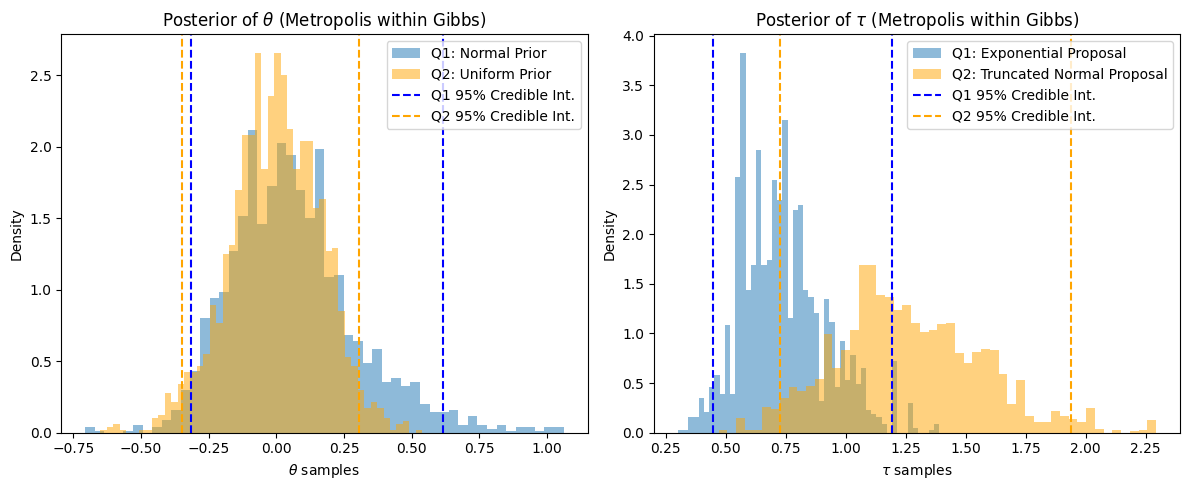

In [ ]:
import numpy as np
from scipy.stats import norm, gamma, uniform, truncnorm
import matplotlib.pyplot as plt

np.random.seed(365)

def joint_posterior_q2(theta, tau, data, theta_min, theta_max, tau0, alpha, lambd):
    """
    Computes the unnormalized joint posterior:
    p(theta, tau | x) ∝ p(x | theta, tau) * p(theta) * p(tau)
    with a Uniform prior for θ instead of a normal prior.
    """
    n = len(data)
    likelihood = norm.pdf(data, loc=theta, scale=1/np.sqrt(tau)).prod()
    # Prior for θ: changed to Uniform(θ_min, θ_max)
    prior_theta = uniform.pdf(theta, loc=theta_min, scale=theta_max - theta_min)
    prior_tau = gamma.pdf(tau, a=alpha, scale=1/lambd)

    return likelihood * prior_theta * prior_tau

def update_theta_q2(theta_current, tau, data, theta_min, theta_max, tau0, alpha, lambd, prop_sd_theta):
    """
    Metropolis update for θ using a normal proposal with a uniform prior.
    """
    # code is the same
    theta_proposed = norm.rvs(loc=theta_current, scale=prop_sd_theta)
    p_proposed = joint_posterior_q2(theta_proposed, tau, data, theta_min, theta_max, tau0, alpha, lambd)
    p_current = joint_posterior_q2(theta_current, tau, data, theta_min, theta_max, tau0, alpha, lambd)
    acceptance_ratio = p_proposed / p_current
    if np.random.rand() < min(1, acceptance_ratio):
        return theta_proposed
    return theta_current

def update_tau_q2(theta, tau_current, data, theta_min, theta_max, tau0, alpha, lambd, s=0.5):
    """
    Different metreopolis update step for τ.
    """
    # Propose a new τ using the dependent proposal, centered at τ_current (aka: previous τ-1)
    tau_proposed = truncnorm.rvs(a=-tau_current/s, b=np.Inf, loc=tau_current, scale=s)

    p_proposed = joint_posterior_q2(theta, tau_proposed, data, theta_min, theta_max, tau0, alpha, lambd)
    p_current = joint_posterior_q2(theta, tau_current, data, theta_min, theta_max, tau0, alpha, lambd)

    # new acceptance probability:
    proposal_ratio = truncnorm.pdf(tau_current, a=-tau_proposed/s, b=np.inf, loc=tau_proposed, scale=s) / \
                     truncnorm.pdf(tau_proposed, a=-tau_current/s, b=np.inf, loc=tau_current, scale=s)

    # rest of code is the same
    acceptance_ratio = (p_proposed / p_current) * proposal_ratio
    if np.random.rand() < min(1, acceptance_ratio):
        return tau_proposed
    return tau_current

def metropolis_within_gibbs_q2(n, m, s, theta_min, theta_max, tau0, alpha, lambd, num_iter=5000, burn_in=20, prop_sd_theta=0.1):
    """
    Updated etropolis-within-Gibbs sampler for Normal(mean=theta, precision=tau)
    This uses a uniform prior for θ, dependent proposal for τ
    """
    # this code is mostly unchanged except comments
    x = norm.rvs(loc=m, scale=s, size=n)
    theta_samples = np.zeros(num_iter)
    tau_samples = np.zeros(num_iter)
    tau_current = gamma.rvs(a=alpha, scale=1/lambd)

    theta_current = uniform.rvs(loc=theta_min, scale=theta_max - theta_min)  # use different prior

    for t in range(num_iter):
        theta_current = update_theta_q2(theta_current, tau_current, x, theta_min, theta_max, tau0, alpha, lambd, prop_sd_theta)

        tau_current = update_tau_q2(theta_current, tau_current, x, theta_min, theta_max, tau0, alpha, lambd) # uses new proposal

        theta_samples[t] = theta_current
        tau_samples[t] = tau_current

    theta_samples = theta_samples[burn_in:]
    tau_samples = tau_samples[burn_in:]
    alpha_ci = (1 - 0.95) / 2
    theta_ci = np.percentile(theta_samples, [100 * alpha_ci, 100 * (1 - alpha_ci)])
    tau_ci = np.percentile(tau_samples, [100 * alpha_ci, 100 * (1 - alpha_ci)])

    return theta_samples, tau_samples, theta_ci, tau_ci

# Run the updated Metropolis-within-Gibbs sampler
theta_samples_q2, tau_samples_q2, theta_ci_q2, tau_ci_q2 = metropolis_within_gibbs_q2(
    n=30, m=0, s=1, theta_min=-1, theta_max=1, tau0=1, alpha=2, lambd=2, num_iter=2000)

# Run the original Metropolis-within-Gibbs sampler (Q1)
theta_samples_q1, tau_samples_q1, theta_ci_q1, tau_ci_q1 = metropolis_within_gibbs(
    n=30, m=0, s=1, theta_0=0, tau_0=1, alpha=2, lambd=2, num_iter=2000)

# Plot overlaid posterior distributions for θ
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Posterior of θ
ax[0].hist(theta_samples_q1, bins=50, density=True, alpha=0.5, label="Q1: Normal Prior")
ax[0].hist(theta_samples_q2, bins=50, density=True, alpha=0.5, label="Q2: Uniform Prior", color="orange")

# Add credible intervals
ax[0].axvline(theta_ci_q1[0], color='blue', linestyle='dashed', label="Q1 95% Credible Int.")
ax[0].axvline(theta_ci_q1[1], color='blue', linestyle='dashed')
ax[0].axvline(theta_ci_q2[0], color='orange', linestyle='dashed', label="Q2 95% Credible Int.")
ax[0].axvline(theta_ci_q2[1], color='orange', linestyle='dashed')

ax[0].set_title(r"Posterior of $\theta$ (Metropolis within Gibbs)")
ax[0].set_xlabel(r"$\theta$ samples")
ax[0].set_ylabel("Density")
ax[0].legend()

# Posterior of τ
ax[1].hist(tau_samples_q1, bins=50, density=True, alpha=0.5, label=r"Q1: Exponential Proposal")
ax[1].hist(tau_samples_q2, bins=50, density=True, alpha=0.5, label=r"Q2: Truncated Normal Proposal", color="orange")

# Add credible intervals
ax[1].axvline(tau_ci_q1[0], color='blue', linestyle='dashed', label="Q1 95% Credible Int.")
ax[1].axvline(tau_ci_q1[1], color='blue', linestyle='dashed')
ax[1].axvline(tau_ci_q2[0], color='orange', linestyle='dashed', label="Q2 95% Credible Int.")
ax[1].axvline(tau_ci_q2[1], color='orange', linestyle='dashed')

ax[1].set_title(r"Posterior of $\tau$ (Metropolis within Gibbs)")
ax[1].set_xlabel(r"$\tau$ samples")
ax[1].set_ylabel("Density")
ax[1].legend()

plt.tight_layout()
plt.show()


The posterior distributions for θ are similar between Q1 and Q2, despite the change from a normal to a uniform prior. This suggests that the prior is less important; when using Metropolis-Hastings, the choice of prior has a much smaller effect than the data itself, showing that we do not need to analytically determine the full conditional for the prior, since we do not directly sample from full conditionals like in Gibbs sampling.

However, the posterior for τ differs significantly- the truncated normal proposal leads to a higher concentration of larger τ values compared to the exponential proposal. This demonstrates that the choice of proposal distribution can meaningfully affect sampling behavior by influencing the rejection rate and convergence. While we do not need full conditionals when using Metropolis-Hastings, the proposal distribution remains important and we must make sure to tune our choice when sampling.


### Q3

For **Metropolis Hastings** targeting (**stationary distribution**) $p$ based on proposal distribution $q$ given below


$\begin{align}
q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \quad \color{gray}{\textrm{ ... does } \quad \frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})} \quad  \textrm{ cancel? (yes, symmetric)}}\\
\textrm{and} \quad p(x^{(t)}) &={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}}\\
\end{align}$


<u>show that</u> the **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is


$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$


> For example
>
> $\begin{align}
\Pr(s_1 \rightarrow s_1) &={}
q(\tilde x^{(t)}=1 | x^{(t-1)}=1) + q(\tilde x^{(t)}=0 | x^{(t-1)}=1) \left(1- \frac{p(\tilde x^{(t)}=0)}{p(x^{(t-1)}=1)}\right)\\
&={} 1/2 + (1/2)(1-(1/3)/(2/3)) = 0.75
\end{align}$



This means that

- if we're currently a $0$ there's a 50\% chance that we'll stay a $0$ and 50\% chance that we'll change to a $1$
- and if we're currently a $1$ there's a 75\% chance that we'll stay a $1$ and 25\% chance that we'll change to a $0$

which specifies [geometric distributions](https://en.wikipedia.org/wiki/Geometric_distribution) with, respectively, expected values of $1$ and $3$ "failures before transitioning to the other state" which means that on average a "$0$ state" will be a run of two $0$'s while a "$1$ state" will be a run of four $1$'s which leads to the desired one-to-two (or one-thirds to two-thirds) ratio of $0$'s and $1$ is the Markov Chain.


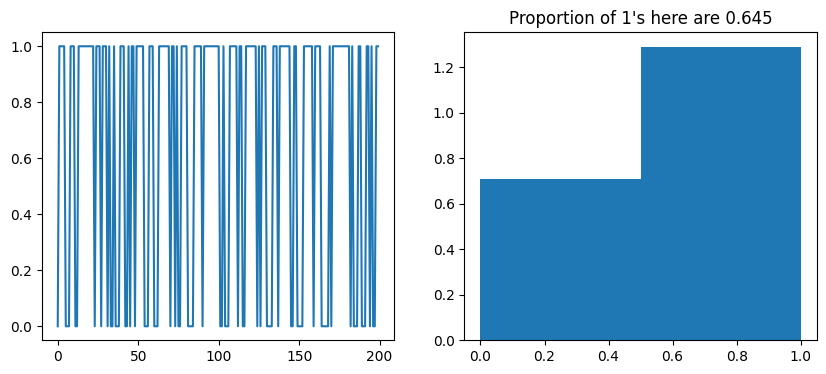

In [ ]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
# Here's what it looks like if we flip coins
# with transition probabilties defind by A sequentially
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
K = np.array([[.5,.25],[.5,.75]])
T = 200
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])

fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(s_t)
ax[1].hist(s_t, bins=2, density=True)
ax[1].set_title("Proportion of 1's here are "+str(s_t.mean()));

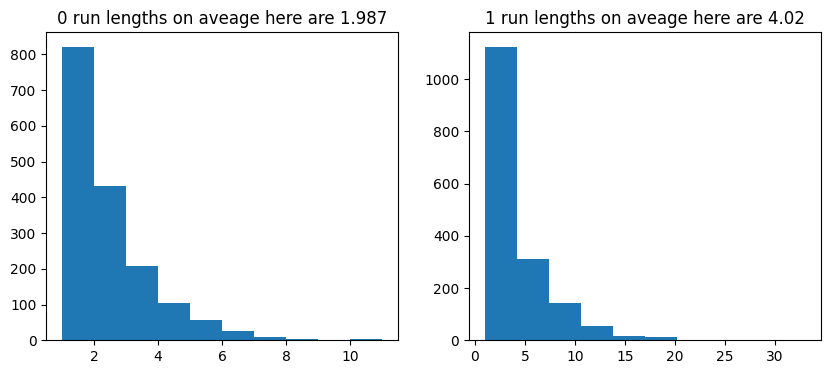

In [ ]:
# Here's what it looks like if we flip coins
# with transition probabilties defind by K
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
T = 10000
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])

state0_run_length = []
state1_run_length = []
run_length = 1
for t in range(1,T):
    if s_t[t]==s_t[t-1]:
        run_length += 1
    else:
        if s_t[t-1] == 0:
            state0_run_length += [run_length]
        else:
            state1_run_length += [run_length]
        run_length = 1

fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(state0_run_length)
ax[0].set_title("0 run lengths on aveage here are "+str(np.mean(state0_run_length).round(3)))
ax[1].hist(state1_run_length)
ax[1].set_title("1 run lengths on aveage here are "+str(np.mean(state1_run_length).round(3)));


To show that the transition kernel K is defined as follows, we can compute the probabilites in the matrix. Note that the derivation for final term $\Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1$ is already given in the example.

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$

$\Pr(s_0 \rightarrow s_0) =
q(\tilde x^{(t)}=0 | x^{(t-1)}=0) + q(\tilde x^{(t)}=1 | x^{(t-1)}=0) \left(1- \min\left(1, \frac{p(\tilde x^{(t)}=1)}{p(x^{(t-1)}=0)}\right)\right)$

$
= \frac{1}{2} + \left(\frac{1}{2}\right) \left(1- \min\left(1, \frac{2/3}{1/3}\right)\right) = \frac{1}{2} + \left(\frac{1}{2}\right) (1-1) = 0.5.
$

$\Pr(s_0 \rightarrow s_1) = q(\tilde x^{(t)}=1 | x^{(t-1)}=0) \min\left(1, \frac{p(\tilde x^{(t)}=1)}{p(x^{(t-1)}=0)}\right) = \frac{1}{2}( \min\left(1, \frac{2/3}{1/3}\right)) = \left(\frac{1}{2}\right) \times 1 = 0.5$

$\Pr(s_1 \rightarrow s_0) =
q(\tilde x^{(t)}=0 | x^{(t-1)}=1) \min\left(1, \frac{p(\tilde x^{(t)}=0)}{p(x^{(t-1)}=1)}\right)= \frac{1}{2}( \min\left(1, \frac{1/3}{2/3}\right)) = \frac{1}{2} \left(\frac{1}{2}\right) = 0.25$

Thus, all transition probabilities in $K$ are verified.